In [5]:
import numpy as np
import pandas as pd

# visualization
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns

from stimuli import generate_sequence, encode_input, Dataset
from snn_params import Params
from snn_network import SNN
from plots import plot_scores, plot_trial         # for ploting classification accuracies

from util import load, save

plt.style.use('seaborn-notebook')                 # change theme to prettier one
plt.rcParams.update({'figure.figsize': (10, 8)})  # increase figure size
plt.rcParams.update({'font.size': 16})            # incrase font size

# Network

In [2]:
net = load("/project/3011085.04/snn/data/raw/recording_reset.pkl")

## Rate tuning

Average rate computed as:
```  
def avg_frate(self):

stim_time = 0.05  # in seconds, 50 milliseconds stimulation time
n_trl = self.recording["count"].shape[0]

total_time = n_trl * stim_time
total_spikes = np.sum(self.recording["count"], axis=0)

frate = total_spikes / total_time  # firing rate per neuron

# mean over active neurons
#activated = self.recording["spikes"].any(axis=2).any(axis=0)
mean = np.mean(frate)
std = np.std(frate)
```

In [3]:
# compute mean
r = net.avg_frate()
m = np.array(r)
m[:] = np.mean(r)

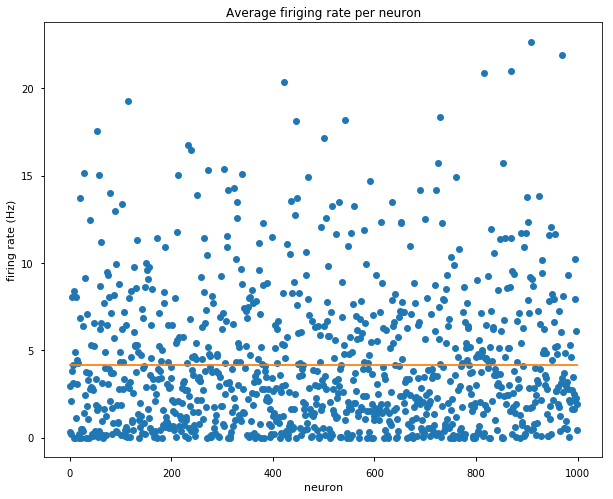

In [6]:
# plot firing rates
plt.figure()
plt.plot(r, 'o')
plt.plot(m)
plt.title("Average firiging rate per neuron")
plt.xlabel("neuron")
plt.ylabel("firing rate (Hz)")
plt.show()

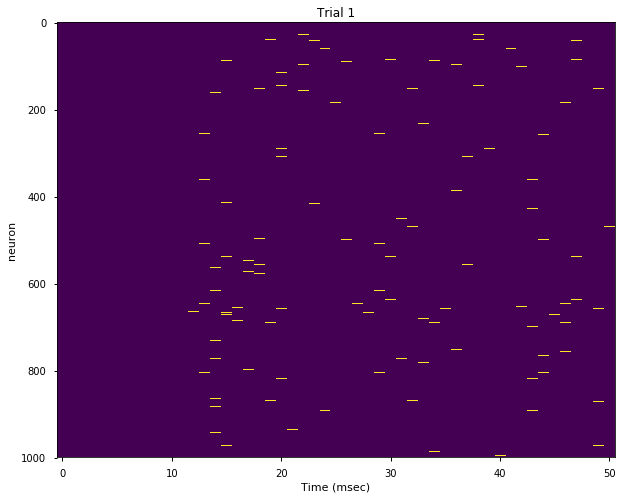

In [7]:
plot_trial(model=net, trial=1, variable="spikes")

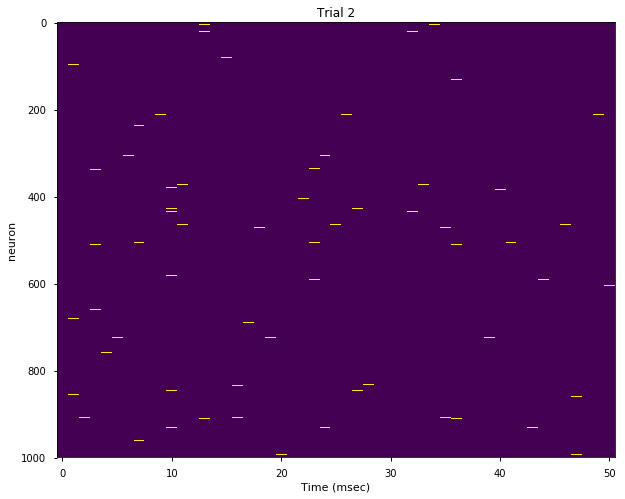

In [8]:
plot_trial(model=net, trial=2, variable="spikes")

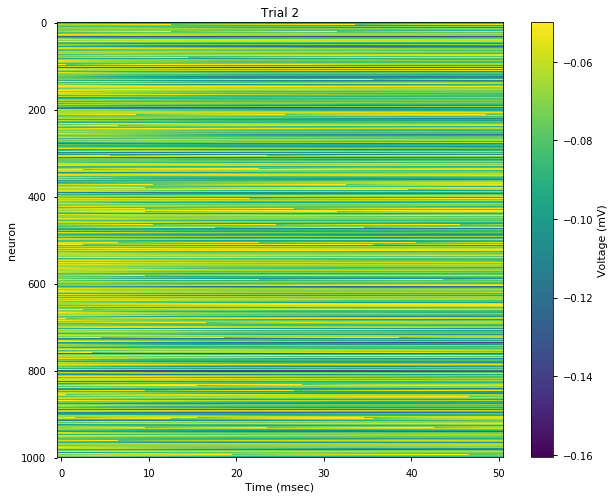

In [9]:
plot_trial(model=net, trial=2, variable="V")

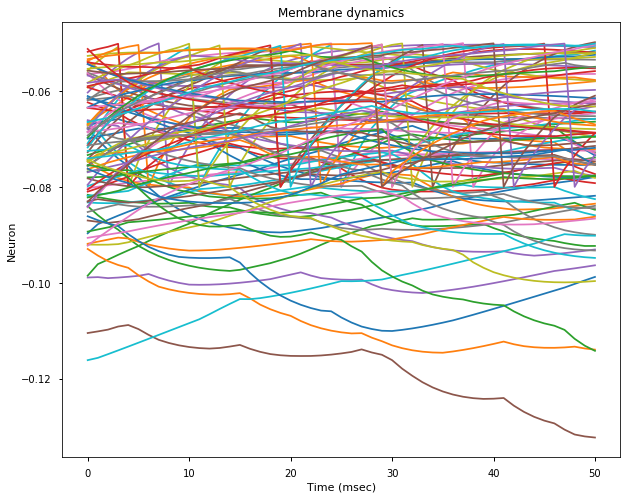

(1060, 1000, 51)


In [10]:
plt.figure()
plt.plot(net.recording["V"][4, ::10, :].T)
plt.title("Membrane dynamics")
plt.xlabel("Time (msec)")
plt.ylabel("Neuron")
plt.show()
print(net.recording["V"].shape)

## Features (avg. membrane)

```
def avg_states(self, toi=None):

"""
Compute average membrane voltage per neuron per trial

:param data: array of membrane voltage (trial x neurons x time) created in net.config_recording().
:param toi: list of integers, onset and offset times
:return out: ndarray (trials x neurons), average voltage
"""

if toi is None:
    toi = [0, 0.05]

# get timing sample points
ton = (np.abs(self.recording["t"] - toi[0])).argmin()
toff = (np.abs(self.recording["t"] - toi[1])).argmin()

# take average over selected time period
out = np.nanmean(a=self.recording["V"][:, :, ton:toff], axis=2)

return out
```

In [11]:
x = load("/project/3011085.04/snn/data/interim/average_states_reset.pkl")
x_cons = load("/project/3011085.04/snn/data/interim/average_states_constructed.pkl")  # data with added 0.3 mV on correct responses

In [12]:
print(x.shape, x_cons.shape)

(1060, 1000) (1060, 1000)


### Original

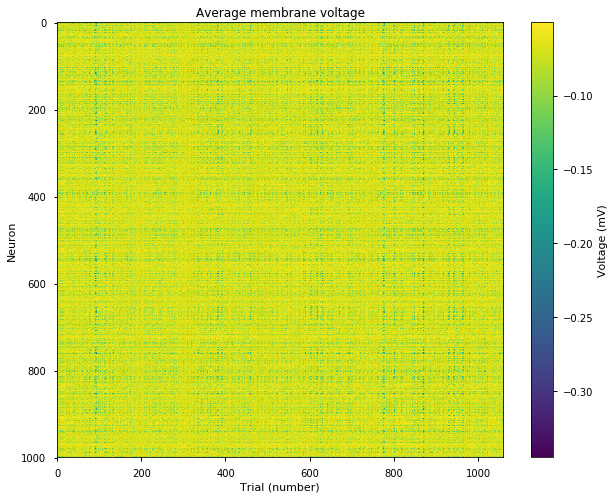

In [13]:
# Plot original data
plt.figure()
plt.imshow(x.T, aspect="auto")
plt.title("Average membrane voltage")
plt.xlabel("Trial (number)")
plt.ylabel("Neuron")
c = plt.colorbar()
c.set_label("Voltage (mV)")
plt.show()

### Constructed

Code:
```
# load the actual data
x = load("/project/3011085.04/snn/data/interim/average_states.pkl")
y = load("/project/3011085.04/snn/data/interim/responses.pkl")

# create fake data
x2 = np.array(x)
x2[y] += 0.03  # add systematic average increase of 0.03 mV
```

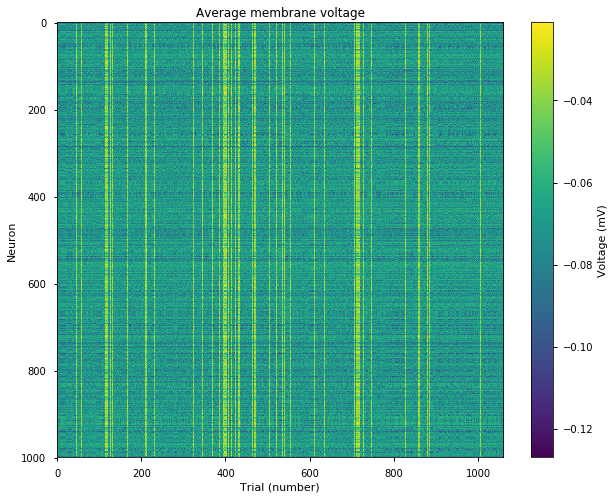

In [14]:
# Plot constructed data
plt.figure()
plt.imshow(x_cons.T, aspect="auto")
plt.title("Average membrane voltage")
plt.xlabel("Trial (number)")
plt.ylabel("Neuron")
c = plt.colorbar()
c.set_label("Voltage (mV)")
plt.show()

## Labels

In [21]:
y = load("/project/3011085.04/snn/data/interim/responses.pkl")
y_surr = load("/project/3011085.04/snn/data/interim/responses_surrogate.pkl")

### Original

In [22]:
print("Number of responses: {}".format(y.shape[0]))
print("Number of 'True' in original: {}".format(np.sum(y)))
print("First 15 indices, original: {}".format(np.where(y == True)[0][0:15]))

Number of responses: 1060
Number of 'True' in original: 132
First 15 indices, original: [  2  30  37  42  46  56  58  61  76  80  82  90  99 104 115]


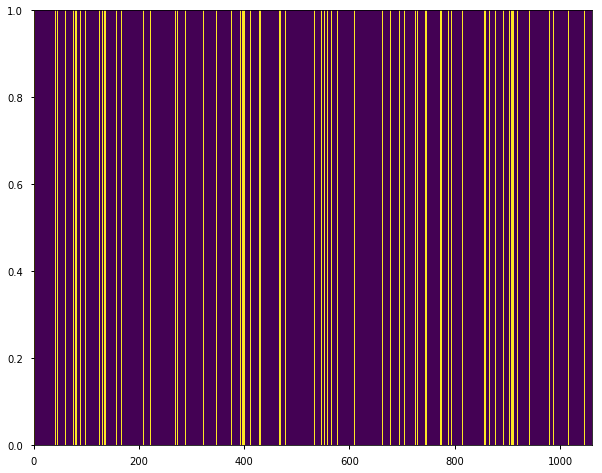

In [23]:
plt.figure()
plt.pcolor(y[:, np.newaxis].T)
plt.show()

### Permuted

In [24]:
print("Number of responses: {}".format(y_surr.shape[0]))
print("Number of 'True' in surrogate: {}".format(np.sum(y_surr)))
print("First 15 indices, surrogate: {}".format(np.where(y_surr == True)[0][0:15]))

Number of responses: 1060
Number of 'True' in surrogate: 132
First 15 indices, surrogate: [ 13  27  35  37  39  40  59  74  75  80 107 111 117 139 141]


## Naive Bayes

### Imbalanced classes (all data)

In [25]:
# load scores
scoresNB = load("/project/3011085.04/snn/data/results/scoresNB_imbalanced.pkl")
scoresSVC = load("/project/3011085.04/snn/data/results/scoresSVC_imbalanced.pkl")

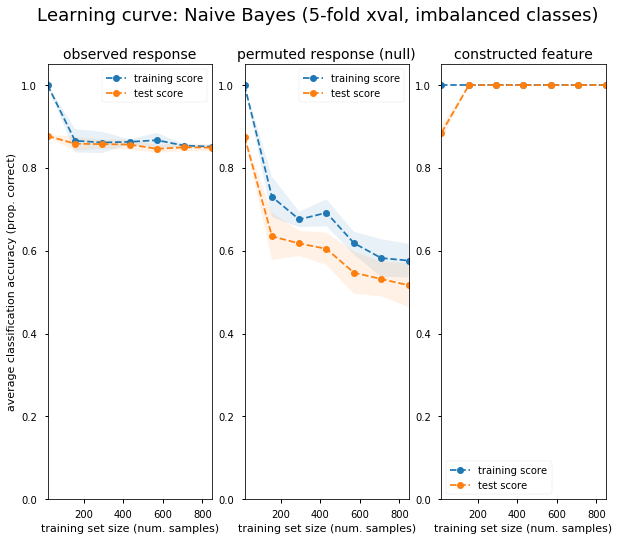

In [26]:
plot_scores(scoresNB, title="Learning curve: Naive Bayes (5-fold xval, imbalanced classes)")

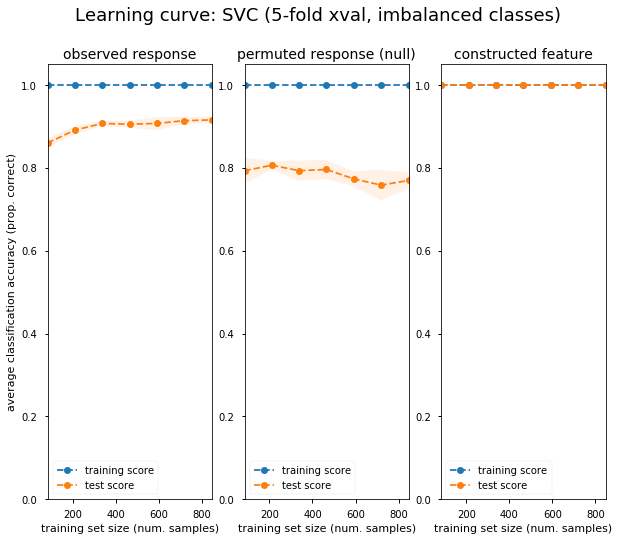

In [27]:
plot_scores(scoresSVC, title="Learning curve: SVC (5-fold xval, imbalanced classes)")

### Balanced classes (subset of data)

In [28]:
scoresNBb = load("/project/3011085.04/snn/data/results/scoresNB_balanced.pkl")
scoresSVCb = load("/project/3011085.04/snn/data/results/scoresSVC_balanced.pkl")

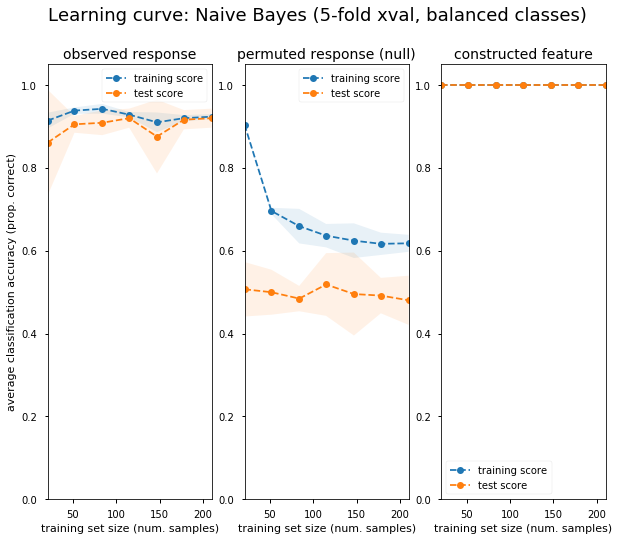

In [29]:
plot_scores(scoresNBb, title="Learning curve: Naive Bayes (5-fold xval, balanced classes)")

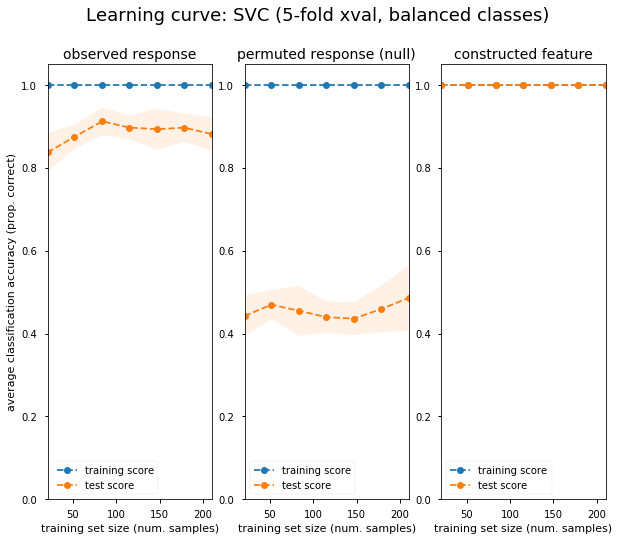

In [30]:
plot_scores(scoresSVCb, title="Learning curve: SVC (5-fold xval, balanced classes)")

## Logistic regression

In [15]:
scoresLR_full = load("/project/3011085.04/snn/data/results/scoresLR_full.pkl")

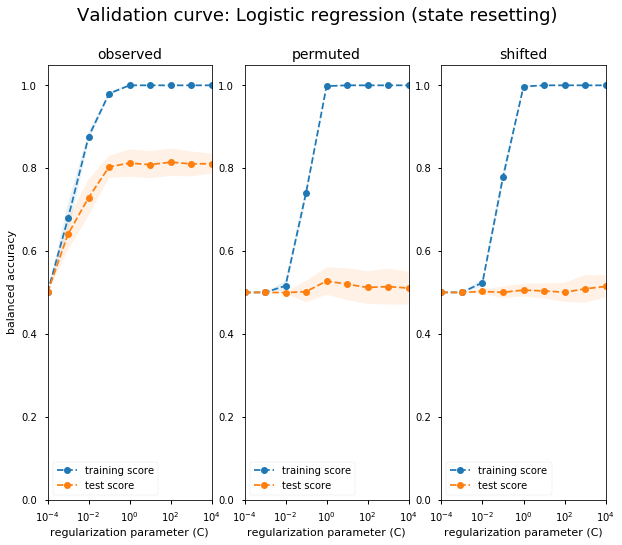

In [17]:
plot_scores(scoresLR_full[0], title="Validation curve: Logistic regression (state resetting)",
            xlabel="regularization parameter (C)", ylabel="balanced accuracy")